In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from tqdm import tqdm
import warnings
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy
from chromATAC.pl import StackPlot


warnings.simplefilter("ignore", category=pd.errors.ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData'

In [4]:
tes_dir = parent_dir+'/data/V2-TEs/non_olap'
cotes_dir = parent_dir+'/data/V2-TEs/cores1000/'

In [5]:
def Cnv_cancertype(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}
    ann = {i:cancer for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    con =  {cancer:i for i, cancer in enumerate(cnv_meta['cancer_type'].unique())}
    for c in tqdm(range(1, 25)):
        samples = chromosome_layer['index'][c]
        conditions[c] = np.array([con[cnv_meta.iloc[np.where(cnv_meta['name']==sample.split('.bed')[0].split(">")[-1])[0]]['cancer_type'].values.item()] for sample in samples if sample.split(".")[0].split(">")[-1] in cnv_meta['name'].values])
        annotations[c] = ann
    return conditions, annotations
def cnv_class_filter(row, **kwargs):
    index_col=kwargs.get('index_col')
    return bool(sample_sig.loc[row.iloc[index_col], row.loc['CN']])

te_dir = parent_dir+'/data/V2-TEs/non_olap'
cote_dir = parent_dir+'/data/V2-TEs/cores1000'

In [6]:
def TE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['TEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [7]:
def CoTE_family(chromosome_layer, **kwargs):
    conditions = {}
    annotations = {}    
    ann = {i:te.split('>')[-1] for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    con = {te.split('>')[-1]:i for i, te in enumerate(ind.chr.layers[1e06]['CoTEs']['index'][1])}
    for chr in range(1, 25):
        conditions[chr] = np.array([con[i.split('>')[-1]] for i in chromosome_layer['index'][chr]])
        annotations[chr] = ann
    return conditions, annotations

In [8]:
# ind.add_layer("CNVAR", input=parent_dir+'/data/CNVAR/segments/beds', feature_type='signal', resolutions=[1e05],)
cnv_meta = pd.read_csv(parent_dir + "/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')
cnv_sig = pd.read_csv('../../notebooks/cnv_sig_reformed.bed', sep='\t')
cnv_sig = cnv_sig[cnv_sig['sample'].apply(lambda x: x in cnv_meta['name'].values)]
cnv_sig['n_copies'] = cnv_sig['n_Major']+cnv_sig['n_Minor']
cnv_sig = cnv_sig.iloc[:,1:10]

sample_sig = pd.read_excel(parent_dir+'/data/CNVAR/sample_signature.xlsx', sheet_name='Pancan sig attributions')
sample_sig = sample_sig.set_index('Sample')

In [11]:
CHROM = 'chr7'
CAN = 'GBM'
qVAL = .05
RES = [1e06]

In [10]:
ind = IntData()
ind.add_layer("TEs", input=te_dir, index_mapper=lambda x: x.split("_Merged.bed")[0], resolutions=[1e6])
ind.add_layer("CoTEs", input=cote_dir, index_mapper=lambda x: x.split("_Merged.bed")[0], resolutions=[1e06])
ind.add_layer("CNVAR", input=cnv_sig, 
              feature_type='signal', 
              index_col=3, 
              feature_column=8, 
              resolutions=[1e06],
              filter_function = cnv_class_filter)
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'], resolutions=[1e06])

loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/non_olap


100%|██████████████████████████████████████████████████████████████████████████████████| 975/975 [00:09<00:00, 98.79it/s]


loading files from: /Users/mossishahi/Code/lupien/IntData/data/V2-TEs/cores1000


100%|████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:46<00:00,  4.45s/it]


In [13]:
ind.add_layer("CNVAR", input=parent_dir+'/data/CNVAR/segments/beds', feature_type='signal', resolutions=[1e06, 1e07],)
cnv_meta = pd.read_csv(parent_dir+"/data/CNVAR/summary.ascatv3TCGA.penalty70.hg38.tsv", sep='\t')

loading files from: /Users/mossishahi/Code/lupien/IntData/data/CNVAR/segments/beds


100%|████████████████████████████████████████████████████████████████████████████| 10679/10679 [00:10<00:00, 1021.21it/s]


In [14]:
ind.chr.add_filter('Cancertype', Cnv_cancertype, ['CNVAR'])

100%|████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:02<00:00,  5.12s/it]


In [15]:
ind.chr.add_filter('te_family', TE_family, ['TEs'])
ind.chr.add_filter('cote_family', CoTE_family, ['CoTEs'])

In [26]:
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTEs = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])

In [27]:
te_meta = pd.read_csv(parent_dir+'/analysis/data/repeat_metadata.onlyTEs_full.tsv', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[0]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d(TEs, COTEs)]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [28]:
te_n_elements = pd.read_csv(tes_dir+'/n_elements_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_elements'])
cote_n_elments = pd.read_csv(cotes_dir+'/n_clusters_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_clusters'])

In [29]:
te_n_elements['name'] = te_n_elements['name'].apply(lambda x: x.split('_Merged.bed')[0])
cote_n_elments['name'] = cote_n_elments['name'].apply(lambda x: x.split('_Merged.bed')[0])
te_df = te_df.merge(te_n_elements, how='left', left_on='repname_numbered', right_on='name').merge(cote_n_elments, how='left', left_on='repname_numbered', right_on='name').drop(['name_x', 'name_y'], axis=1).fillna(0)
te_df.set_index('repname_numbered', inplace=True)

In [146]:
def get_cnv_candidates(CAN, CHROM, parent_dir, qVAL=0.05):
    df1 = pd.read_csv(parent_dir+f'/analysis/experiment100/gain/{CHROM}__n_hits.csv')
    df1.rename({'Unnamed: 0': 'TE'}, axis=1, inplace=True)
    df1['TE'] = df1['TE'].apply(lambda x: x.split('>')[-1])
    df1 = df1.set_index('TE')
    df1 = df1.sort_values(f'CNVAR;Cancertype:{CAN}', ascending=False)
    qval = pd.read_csv(parent_dir+f'/analysis/experiment100/gain/{CHROM}__qval_n_hit.csv')
    qval.rename({'Unnamed: 0': 'TE'}, axis=1, inplace=True)
    qval['TE'] = qval['TE'].apply(lambda x: x.split('>')[-1])
    qval = qval.set_index('TE')
    df2 = qval.sort_values(f'CNVAR;Cancertype:{CAN}').loc[:,[f'CNVAR;Cancertype:{CAN}']]
    candidates = df1[qval.reindex_like(df1).loc[:,f'CNVAR;Cancertype:{CAN}']<=qVAL].loc[:,[f'CNVAR;Cancertype:{CAN}']]
    return candidates, qval[qval.loc[:, f'CNVAR;Cancertype:{CAN}']<qVAL].loc[:, f'CNVAR;Cancertype:{CAN}']

In [170]:
def cnv_cote_mapping(CAN, CHROM):
    candidates, qvals = get_cnv_candidates(CAN, CHROM, parent_dir)
    f = candidates.join(qvals, how='left', lsuffix='hit', rsuffix='qv')
    f.columns = ['CNV_hit_value', 'CNV_qvalue']
    path = parent_dir + '/analysis/results/' + f'{CAN}/'
    if not os.path.isdir(path):
        os.mkdir(path)
    f.to_csv(path+f'{CHROM}.csv')
    return f

In [172]:
f = cnv_cote_mapping('OV', 'chr1')

In [173]:
f

,CNV_hit_value,CNV_qvalue
TE,,
1030_MER57A1,3.828746,0.000000
888_MamGypLTR1a,3.378800,0.034366
811_LTR54,2.908844,0.000000
970_MER34,2.589512,0.000000
305_Charlie22a,1.785796,0.000000
...,...,...
534_L1M4,0.151410,0.000000
89_AluJr,0.146217,0.034366
456_HAL1b,0.128370,0.049304


In [149]:
for CAN in cnv_meta.cancer_type.unique():
    for CHROM in ca.info.CHROMOSOMES['names'][:-1]:
        cnv_cote_mapping(CAN, CHROM)

In [105]:
candidates

,CNVAR;Cancertype:GBM
TE,
1009_MER4D1,2.874133
287_Charlie10,2.315327
1002_MER4A1,2.015726
964_MER31B,1.475269
568_L1MCa,0.668687


In [77]:
def can_to_cote(CAN, CHROM, parent_dir, fig_dir=None, show_plot=True):
    candidates, _ = get_cnv_candidates(CAN, CHROM, parent_dir)   
    candidates = candidates.index
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(len(candidates)+1, 1, figsize=(24, 3*len(candidates)), sharex=True)
    axs = axs.flatten()
    c = ind.chr.get_layer('CNVAR',
                  chrom=CHROM,
                  groups={'Cancertype':CAN},
                 )[f'Cancertype:{CAN}']
    c_data = c['data']
    sns.lineplot(c_data.mean(0), ax=axs[0], color='navy')
    # sns.barplot(100*(c_data>0).sum(0)/c_data.shape[0], ax=axs[1], color='skyblue', alpha=.4)
    axs[0].set_ylabel('Copy Number Average', fontsize=8)
    axs[1].set_ylabel('Samples with CN alteration (%)', fontsize=8)
    
    for i, candidate in enumerate(candidates):
        ct = ind.chr.get_layer('CoTEs',
                          chrom=CHROM,
                          groups={'cote_family':candidate},
                         )[f'cote_family:{candidate}']
        ct_data = ct['data']
        ax = axs[i+1]
        bins = np.arange(ca.info.CHROMOSOMES['lens'][CHROM]/RES[0])
        sns.lineplot(ct_data.mean(0), ax=ax, color='orange')
        ax.set_xticks(bins)
        ax.set_xticklabels(np.arange(1, len(bins) + 1), rotation=90, fontsize=8)
        ax.set_xlabel(f'Chromosome {CHROM.split('chr')[-1]} -  Mega base pairs', fontsize=16)
        ax.set_ylabel(f'{candidate}', fontsize=10)
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle(f'Co occurnces of Copy Number Alteration in cancer type: {CAN} and CoTEs from {candidate} TE family', y=.9)
    if show_plot:
        plt.show()
    # path = fig_dir + f'/{CAN}/' + f'{CHROM}/'
    # if not os.path.exists(path):
    #     os.makedirs(path)
    # fig.savefig(path+f'{CHROM}.png')
    # print(f'fig saved at {path}')

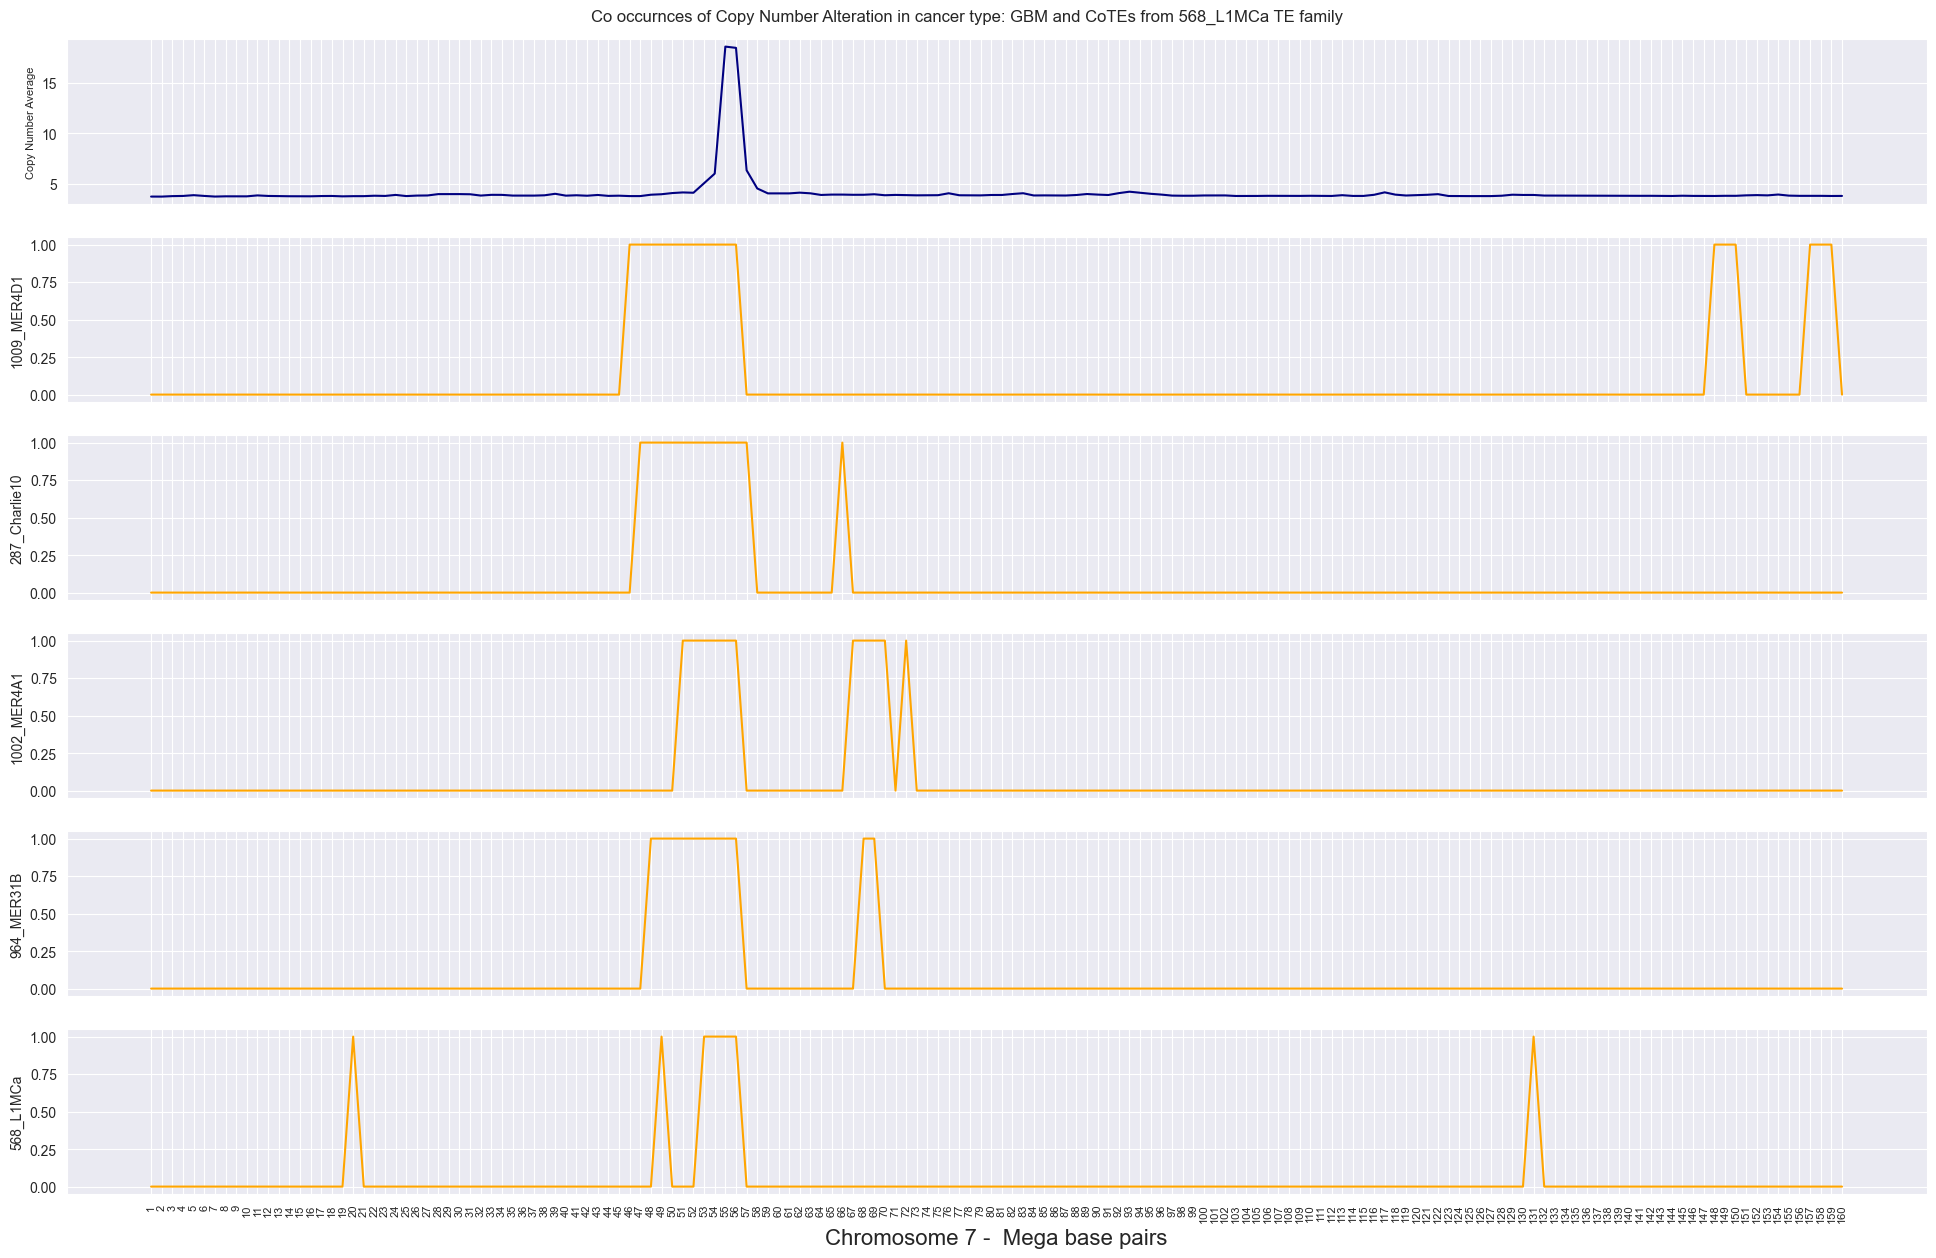

In [78]:
can_to_cote(CAN, CHROM, parent_dir)

In [79]:
def plot_grouped_data_with_stackplot(df, fig_width,fig_height, shade, super_title, super_title_fontsize=16, tick_label_fontsize=10, palette=None):
    # Ensure data is numeric
    df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

    # Check for NaN values in the DataFrame
    if df.isnull().values.any():
        print("Warning: NaN values detected in the DataFrame")

    # Group and sort data
    grouped = df.groupby('cancertype')
    track_heights = grouped.max().max(axis=1)
    sorted_groups = track_heights.sort_values(ascending=True).index.tolist()

    # Calculate the total sum of track heights and the relative heights
    total_height_sum = track_heights.sum()
    relative_heights = [track_height / total_height_sum for track_height in track_heights[sorted_groups]]
    # Initialize StackPlot
    stack_plot = StackPlot(figsize=(fig_width, fig_height), super_title=super_title, palette=palette)
    # Add tracks and plot data
    accumulated_relative_height = 0
    for i, cancer_type in enumerate(sorted_groups):
        relative_track_height = relative_heights[i]
        span_start = accumulated_relative_height
        span_end = accumulated_relative_height + relative_track_height
        accumulated_relative_height = span_end

        # Convert relative span to actual height
        actual_span = (span_start, span_end)

        track = stack_plot.add_track(actual_span, cancer_type)
        group_data = grouped.get_group(cancer_type)
        mean = group_data.iloc[:, :-1].mean()
        max_val = group_data.iloc[:, :-1].max()
        min_val = group_data.iloc[:, :-1].min()

        # Check if index needs to be converted to numeric
        if not np.issubdtype(mean.index.dtype, np.number):
            try:
                mean.index = pd.to_numeric(mean.index)
            except:
                pass  # Keep the original index if conversion fails
        track.lineplot(mean)
        track.add_label(cancer_type, side='right')
        if shade:
            track.fill_between(mean.index, min_val, max_val, alpha=0.3)

    # Render the plot
    stack_plot.render(grid=False)

In [100]:
def plot_grouped_data_with_stackplot(df, fig_width, fig_height, shade, super_title, 
                                     super_title_fontsize=16, tick_label_fontsize=10, palette=None):
    # Ensure data is numeric
    df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

    # Check for NaN values in the DataFrame
    if df.isnull().values.any():
        print("Warning: NaN values detected in the DataFrame")

    # Group and sort data
    grouped = df.groupby('cancertype')
    track_heights = grouped.max().max(axis=1)
    sorted_groups = track_heights.sort_values(ascending=True).index.tolist()

    # Calculate the total sum of track heights and the relative heights
    total_height_sum = track_heights.sum()
    relative_heights = [track_height / total_height_sum for track_height in track_heights[sorted_groups]]
    
    # Initialize StackPlot
    stack_plot = StackPlot(figsize=(fig_width, fig_height), super_title=super_title, palette=palette)
    
    # Add tracks and plot data
    accumulated_relative_height = 0
    for i, cancer_type in enumerate(sorted_groups):
        relative_track_height = relative_heights[i]
        span_start = accumulated_relative_height
        span_end = accumulated_relative_height + relative_track_height
        accumulated_relative_height = span_end

        # Convert relative span to actual height
        actual_span = (span_start, span_end)

        track = stack_plot.add_track(actual_span, cancer_type)
        group_data = grouped.get_group(cancer_type)
        mean = group_data.iloc[:, :-1].mean()
        max_val = group_data.iloc[:, :-1].max()
        min_val = group_data.iloc[:, :-1].min()
        std_dev = group_data.iloc[:, :-1].std()  # Standard deviation

        # Check if index needs to be converted to numeric
        if not np.issubdtype(mean.index.dtype, np.number):
            try:
                mean.index = pd.to_numeric(mean.index)
            except:
                pass  # Keep the original index if conversion fails

        # Plot mean with error bars for standard deviation
        track.errorbar(mean.index, mean, yerr=std_dev, fmt='-o', capsize=5)
        track.add_label(cancer_type, side='right')

        if shade:
            track.fill_between(mean.index, min_val, max_val, alpha=0.3)

    # Render the plot
    stack_plot.render(grid=False)


In [95]:
mapping = ind.chr.groups[1000000.0]['CNVAR']['Cancertype']['annotation'][1]

In [84]:
d = ind.chr.get_layer('CNVAR', chrom=CHROM)
df = pd.DataFrame(d['data'], [i.split('>')[-1] for i in d['index']])

In [96]:
df['cancertype']=ind.chr.groups[1000000.0]['CNVAR']['Cancertype']['condition'][1]
df['cancertype'] = df['cancertype'].map(mapping)

In [102]:
candidates

,CNVAR;Cancertype:GBM
TE,
1009_MER4D1,2.874133
287_Charlie10,2.315327
1002_MER4A1,2.015726
964_MER31B,1.475269
568_L1MCa,0.668687


AttributeError: 'Track' object has no attribute 'errorbar'

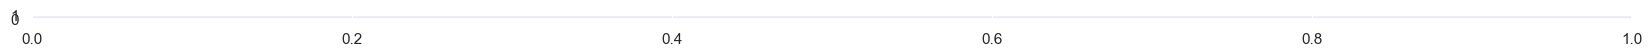

In [101]:
plot_grouped_data_with_stackplot(df, fig_width=20, fig_height=15, shade=True, super_title="CNV - Grouped Cancer Type Analysis", super_title_fontsize=18, tick_label_fontsize=12)